In [18]:
import pandas as pd
import numpy as np
import random
from IPython.display import Image
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import networkx as nx
from networkx.algorithms import community
# Node2Vec
from sklearn.preprocessing import normalize
import math
from tqdm import tqdm
from sklearn.metrics import confusion_matrix


In [19]:
#utility function to get removed edges
def removedEdges(first,second):
    removed = 0
    for edge in first:
        if edge not in second:
            removed+=1
    return removed
#utility function to get added adges
def addedEdges(first,second):
    added = 0
    for edge in second:
        if edge not in first:
            added+=1
    return added

In [20]:
def positiveScoreMatBuild(_graph):
    pred_adamic = list(nx.adamic_adar_index(_graph))
    positive_score_mat = np.zeros((70,70))
    for item in pred_adamic:
        positive_score_mat[item[0]][item[1]] = item[2]
    return positive_score_mat

In [26]:
def _target(mat):
    target = []
    for i in range(len(mat)):
        for j in range(i,len(mat[0])):
            target.append(mat[i][j])
    return target

In [31]:
add_Edges = []
remove_Edges = []
def batchApproach(first,second,batch_size=10):
    #loading matrix of first state
    first_mat = np.loadtxt(first, dtype=int)
    #removing self loops
    for i in range(0,70):
            first_mat[i][i] = 0
    #building graphs
    G_First = nx.from_numpy_matrix(first_mat)
    #print("Number Of Edges: ",len(G_First.edges()))
    #print("Number Of Nodes: ",len(G_First.nodes()))
    #loading matrix of second state
    second_mat = np.loadtxt(second, dtype=int)
    #removing self loops
    for i in range(0,70):
        second_mat[i][i] = 0
    #building graph of second state
    G_second = nx.from_numpy_matrix(second_mat)
    #G_lMCI = nx.from_numpy_matrix(lmci_mat)
    #print("Number Of Edges: ",len(G_second.edges()))
    #print("Number Of Nodes: ",len(G_second.nodes()))
    #print("Number Of Removed Edges: ",removedEdges(G_First.edges(),G_second.edges()))
    #print("Number of new Edges:",addedEdges(G_First.edges(),G_second.edges()))
    #print(second_mat)
    #print(type(second_mat))
    first_pred = second_mat.copy()
    #prepare the positive score matrix
    positive_score_mat = positiveScoreMatBuild(G_First)
    #positive_score_mat = normalize(positive_score_mat, axis=1, norm='l1')
    #preparing negative score matrix
    G_First_complement = nx.complement(G_First)
    negative_score_mat = positiveScoreMatBuild(G_First_complement)
    #negative_score_mat = normalize(negative_score_mat, axis=1, norm='l1')
    #print(negative_score_mat)
    
    A = addedEdges(G_First.edges(),G_second.edges())
    B = removedEdges(G_First.edges(),G_second.edges())
    removed_edges = B
    added_edges = A
    score=(A+B)*2
    laps = math.ceil((A+B)/batch_size)
    done = []
    for m in range(laps):
        positive_score_mat = positiveScoreMatBuild(G_First)
        G_First_complement = nx.complement(G_First)
        negative_score_mat = positiveScoreMatBuild(G_First_complement)

        for n in range(batch_size):
            if(A>0 and B>0):
                maxIndex = 70
                TopRank=-1
                x=0
                y=0
                for i in range(maxIndex-1):
                    for j in range(i+1,maxIndex):
                        if(first_mat[i][j]==0 and (i,j) not in done):
                            #print(i,j)
                            tempRank = positive_score_mat[i][j]
                            if(tempRank>TopRank):
                                x=i
                                y=j
                                TopRank = tempRank
                #positive_score_mat[x][y] = -positive_score_mat[x][y]
                if(positive_score_mat[x][y]>negative_score_mat[x][y]):
                    #adding link
                    add_Edges.append((x,y,positive_score_mat[x][y],negative_score_mat[x][y]))
                    first_pred[x][y] = 1
                    A-=1
                    done.append((x,y))
                    G_First.add_edge(x,y)
                elif(first_pred[x][y]==1):
                    #removing edge
                    remove_Edges.append((x,y,positive_score_mat[x][y],negative_score_mat[x][y]))
                    first_pred[x][y] = 0
                    B-=1
                    #print(x,y)
                    done.append((x,y))
                    G_First.remove_edge(x, y)
                else:
                    done.append((x,y))
    
        
    
            if(A>0):
                maxIndex = 70
                TopRank=-1
                x=0
                y=0
                for i in range(maxIndex-1):
                    for j in range(i+1,maxIndex):
                        if(first_mat[i][j]==0 and (i,j) not in done):
                            tempRank = positive_score_mat[i][j]
                            if(tempRank>TopRank):
                                x=i
                                y=j
                                TopRank = tempRank
        
                first_pred[x][y] = 1
                A-=1
                done.append((x,y))
                add_Edges.append((x,y,positive_score_mat[x][y],negative_score_mat[x][y]))
                G_First.add_edge(x,y)
                
        
                #print(x,y)
            if(B>0):
                maxIndex = 70
                TopRank=-1
                x=0
                y=0
                for i in range(maxIndex-1):
                    for j in range(i+1,maxIndex):
                        if(first_mat[i][j]==1 and (i,j) not in done):
                            tempRank = negative_score_mat[i][j]
                            if(tempRank>TopRank):
                                x=i
                                y=j
                                TopRank = tempRank
        
                first_pred[x][y] = 0
                remove_Edges.append((x,y,positive_score_mat[x][y],negative_score_mat[x][y]))
                G_First.remove_edge(x, y)
                B-=1
                done.append((x,y))
    diff = np.subtract(second_mat,first_pred)    
    dist = 0
    removed_pred = 0
    added_pred = 0
    for i in range(70):
        for j in range(i,70):
            if diff[i][j]!=0:
                dist+=1
            if diff[i][j]==-1:
                removed_pred+=1
            if diff[i][j]==1:
                added_pred+=1
    #print("score: ",score)
    #removal accuracy
    
    matching  = (score-dist)/score
    removed_accuracy = removed_pred/(2*removed_edges)
    added_accuracy = added_pred/(2*added_edges)
    actual_ = _target(second_mat)
    predicted_ = _target(first_pred)
    print("removed Matching Score:: ",removed_accuracy)
    print("added Matching Score:: ",added_accuracy)
    print("confusion matrix",confusion_matrix(actual_,predicted_))
    
    #print("Matching Score:: ",matching)
    #print(len(done))
    return matching


  0%|          | 0/19 [00:00<?, ?it/s]

removed Matching Score::  0.5316455696202531
added Matching Score::  0.37373737373737376
confusion matrix [[1796   84]
 [  74 2946]]



  5%|▌         | 1/19 [01:34<28:18, 94.36s/it]

removed Matching Score::  0.5316455696202531
added Matching Score::  0.3787878787878788
confusion matrix [[1796   84]
 [  75 2945]]



 11%|█         | 2/19 [02:34<23:48, 84.03s/it]

removed Matching Score::  0.5316455696202531
added Matching Score::  0.37373737373737376
confusion matrix [[1796   84]
 [  74 2946]]



 16%|█▌        | 3/19 [03:09<18:29, 69.33s/it]

removed Matching Score::  0.5126582278481012
added Matching Score::  0.3686868686868687
confusion matrix [[1799   81]
 [  73 2947]]



 21%|██        | 4/19 [03:35<14:04, 56.27s/it]

removed Matching Score::  0.5189873417721519
added Matching Score::  0.37373737373737376
confusion matrix [[1798   82]
 [  74 2946]]



 26%|██▋       | 5/19 [03:57<10:45, 46.14s/it]

removed Matching Score::  0.5189873417721519
added Matching Score::  0.3787878787878788
confusion matrix [[1798   82]
 [  75 2945]]



 32%|███▏      | 6/19 [04:13<08:00, 36.93s/it]

removed Matching Score::  0.5189873417721519
added Matching Score::  0.37373737373737376
confusion matrix [[1798   82]
 [  74 2946]]



 37%|███▋      | 7/19 [04:29<06:10, 30.86s/it]

removed Matching Score::  0.5126582278481012
added Matching Score::  0.3686868686868687
confusion matrix [[1799   81]
 [  73 2947]]



 42%|████▏     | 8/19 [04:47<04:54, 26.82s/it]

removed Matching Score::  0.5063291139240507
added Matching Score::  0.3787878787878788
confusion matrix [[1800   80]
 [  75 2945]]



 47%|████▋     | 9/19 [04:59<03:43, 22.36s/it]

removed Matching Score::  0.5126582278481012
added Matching Score::  0.3787878787878788
confusion matrix [[1799   81]
 [  75 2945]]



 53%|█████▎    | 10/19 [05:09<02:47, 18.66s/it]

removed Matching Score::  0.5126582278481012
added Matching Score::  0.37373737373737376
confusion matrix [[1799   81]
 [  74 2946]]



 58%|█████▊    | 11/19 [05:19<02:08, 16.06s/it]

removed Matching Score::  0.5126582278481012
added Matching Score::  0.3787878787878788
confusion matrix [[1799   81]
 [  75 2945]]



 63%|██████▎   | 12/19 [05:31<01:45, 15.03s/it]

removed Matching Score::  0.5126582278481012
added Matching Score::  0.37373737373737376
confusion matrix [[1799   81]
 [  74 2946]]



 68%|██████▊   | 13/19 [05:45<01:28, 14.67s/it]

removed Matching Score::  0.5126582278481012
added Matching Score::  0.37373737373737376
confusion matrix [[1799   81]
 [  74 2946]]



 74%|███████▎  | 14/19 [05:57<01:09, 13.86s/it]

removed Matching Score::  0.5126582278481012
added Matching Score::  0.37373737373737376
confusion matrix [[1799   81]
 [  74 2946]]



 79%|███████▉  | 15/19 [06:07<00:51, 12.81s/it]

removed Matching Score::  0.5126582278481012
added Matching Score::  0.37373737373737376
confusion matrix [[1799   81]
 [  74 2946]]



 84%|████████▍ | 16/19 [06:16<00:34, 11.41s/it]

removed Matching Score::  0.5126582278481012
added Matching Score::  0.37373737373737376
confusion matrix [[1799   81]
 [  74 2946]]



 89%|████████▉ | 17/19 [06:27<00:23, 11.54s/it]

removed Matching Score::  0.5253164556962026
added Matching Score::  0.37373737373737376
confusion matrix [[1797   83]
 [  74 2946]]



 95%|█████████▍| 18/19 [06:35<00:10, 10.27s/it]

removed Matching Score::  0.5126582278481012
added Matching Score::  0.37373737373737376
confusion matrix [[1799   81]
 [  74 2946]]



100%|██████████| 19/19 [06:43<00:00, 21.22s/it]


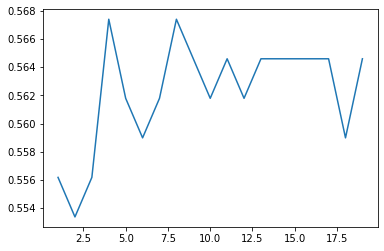

In [32]:
add_Edges = []
remove_Edges = []
accuracy = []
x = [i for i in range(1,20)]
for b in tqdm(range(1,20)):
    acc = batchApproach('../Normal.txt','../eMCI.txt',batch_size=b)
    accuracy.append(acc)
plt.plot(x,accuracy)
plt.show()


  0%|          | 0/19 [00:00<?, ?it/s]

removed Matching Score::  0.10632183908045977
added Matching Score::  1.7272727272727273
confusion matrix [[2103   37]
 [ 152 2608]]



  5%|▌         | 1/19 [02:00<36:04, 120.27s/it]

removed Matching Score::  0.10632183908045977
added Matching Score::  1.7159090909090908
confusion matrix [[2103   37]
 [ 151 2609]]



 11%|█         | 2/19 [03:02<29:10, 102.96s/it]

removed Matching Score::  0.10632183908045977
added Matching Score::  1.7045454545454546
confusion matrix [[2103   37]
 [ 150 2610]]



 16%|█▌        | 3/19 [03:42<22:23, 83.97s/it] 

removed Matching Score::  0.10632183908045977
added Matching Score::  1.7045454545454546
confusion matrix [[2103   37]
 [ 150 2610]]



 21%|██        | 4/19 [04:19<17:29, 69.97s/it]

removed Matching Score::  0.10344827586206896
added Matching Score::  1.7159090909090908
confusion matrix [[2104   36]
 [ 151 2609]]



 26%|██▋       | 5/19 [04:46<13:19, 57.08s/it]

removed Matching Score::  0.10344827586206896
added Matching Score::  1.7272727272727273
confusion matrix [[2104   36]
 [ 152 2608]]



 32%|███▏      | 6/19 [05:15<10:31, 48.56s/it]

removed Matching Score::  0.10344827586206896
added Matching Score::  1.7272727272727273
confusion matrix [[2104   36]
 [ 152 2608]]



 37%|███▋      | 7/19 [05:33<07:53, 39.44s/it]

removed Matching Score::  0.10057471264367816
added Matching Score::  1.75
confusion matrix [[2105   35]
 [ 154 2606]]



 42%|████▏     | 8/19 [05:51<06:02, 32.98s/it]

removed Matching Score::  0.10344827586206896
added Matching Score::  1.7386363636363635
confusion matrix [[2104   36]
 [ 153 2607]]



 47%|████▋     | 9/19 [06:07<04:39, 27.97s/it]

removed Matching Score::  0.09770114942528736
added Matching Score::  1.7613636363636365
confusion matrix [[2106   34]
 [ 155 2605]]



 53%|█████▎    | 10/19 [06:23<03:38, 24.30s/it]

removed Matching Score::  0.10057471264367816
added Matching Score::  1.75
confusion matrix [[2105   35]
 [ 154 2606]]



 58%|█████▊    | 11/19 [06:36<02:46, 20.86s/it]

removed Matching Score::  0.10057471264367816
added Matching Score::  1.7613636363636365
confusion matrix [[2105   35]
 [ 155 2605]]



 63%|██████▎   | 12/19 [06:54<02:19, 19.95s/it]

removed Matching Score::  0.10057471264367816
added Matching Score::  1.7613636363636365
confusion matrix [[2105   35]
 [ 155 2605]]



 68%|██████▊   | 13/19 [07:09<01:50, 18.40s/it]

removed Matching Score::  0.10057471264367816
added Matching Score::  1.7613636363636365
confusion matrix [[2105   35]
 [ 155 2605]]



 74%|███████▎  | 14/19 [07:20<01:22, 16.41s/it]

removed Matching Score::  0.10057471264367816
added Matching Score::  1.7613636363636365
confusion matrix [[2105   35]
 [ 155 2605]]



 79%|███████▉  | 15/19 [07:31<00:58, 14.64s/it]

removed Matching Score::  0.10344827586206896
added Matching Score::  1.6931818181818181
confusion matrix [[2104   36]
 [ 149 2611]]



 84%|████████▍ | 16/19 [07:42<00:40, 13.55s/it]

removed Matching Score::  0.10344827586206896
added Matching Score::  1.6931818181818181
confusion matrix [[2104   36]
 [ 149 2611]]



 89%|████████▉ | 17/19 [07:52<00:24, 12.43s/it]

removed Matching Score::  0.10344827586206896
added Matching Score::  1.7045454545454546
confusion matrix [[2104   36]
 [ 150 2610]]



 95%|█████████▍| 18/19 [08:01<00:11, 11.51s/it]

removed Matching Score::  0.10057471264367816
added Matching Score::  1.7386363636363635
confusion matrix [[2105   35]
 [ 153 2607]]



100%|██████████| 19/19 [08:11<00:00, 25.86s/it]


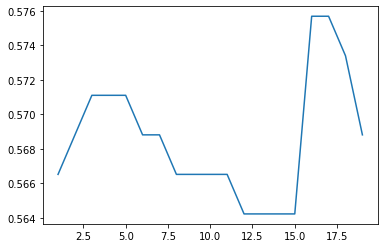

In [33]:
add_Edges = []
remove_Edges = []
accuracy = []
x = [i for i in range(1,20)]
for b in tqdm(range(1,20)):
    acc = batchApproach('../eMCI.txt','../lMCI.txt',batch_size=b)
    accuracy.append(acc)
plt.plot(x,accuracy)
plt.show()


  0%|          | 0/19 [00:00<?, ?it/s]

removed Matching Score::  0.34444444444444444
added Matching Score::  0.5675675675675675
confusion matrix [[2110   62]
 [  84 2644]]



  5%|▌         | 1/19 [01:29<26:56, 89.79s/it]

removed Matching Score::  0.3388888888888889
added Matching Score::  0.5675675675675675
confusion matrix [[2111   61]
 [  84 2644]]



 11%|█         | 2/19 [02:19<21:59, 77.62s/it]

removed Matching Score::  0.3333333333333333
added Matching Score::  0.5675675675675675
confusion matrix [[2112   60]
 [  84 2644]]



 16%|█▌        | 3/19 [02:56<17:27, 65.49s/it]

removed Matching Score::  0.3388888888888889
added Matching Score::  0.5675675675675675
confusion matrix [[2111   61]
 [  84 2644]]



 21%|██        | 4/19 [03:18<13:09, 52.66s/it]

removed Matching Score::  0.3388888888888889
added Matching Score::  0.5675675675675675
confusion matrix [[2111   61]
 [  84 2644]]



 26%|██▋       | 5/19 [03:42<10:16, 44.04s/it]

removed Matching Score::  0.3333333333333333
added Matching Score::  0.5675675675675675
confusion matrix [[2112   60]
 [  84 2644]]



 32%|███▏      | 6/19 [04:01<07:53, 36.43s/it]

removed Matching Score::  0.35555555555555557
added Matching Score::  0.5675675675675675
confusion matrix [[2108   64]
 [  84 2644]]



 37%|███▋      | 7/19 [04:15<05:56, 29.69s/it]

removed Matching Score::  0.3388888888888889
added Matching Score::  0.5675675675675675
confusion matrix [[2111   61]
 [  84 2644]]



 42%|████▏     | 8/19 [04:28<04:31, 24.71s/it]

removed Matching Score::  0.34444444444444444
added Matching Score::  0.5675675675675675
confusion matrix [[2110   62]
 [  84 2644]]



 47%|████▋     | 9/19 [04:44<03:42, 22.22s/it]

removed Matching Score::  0.3388888888888889
added Matching Score::  0.5675675675675675
confusion matrix [[2111   61]
 [  84 2644]]



 53%|█████▎    | 10/19 [04:57<02:53, 19.32s/it]

removed Matching Score::  0.3333333333333333
added Matching Score::  0.5608108108108109
confusion matrix [[2112   60]
 [  83 2645]]



 58%|█████▊    | 11/19 [05:07<02:11, 16.50s/it]

removed Matching Score::  0.3388888888888889
added Matching Score::  0.5608108108108109
confusion matrix [[2111   61]
 [  83 2645]]



 63%|██████▎   | 12/19 [05:16<01:40, 14.31s/it]

removed Matching Score::  0.3277777777777778
added Matching Score::  0.5675675675675675
confusion matrix [[2113   59]
 [  84 2644]]



 68%|██████▊   | 13/19 [05:25<01:15, 12.52s/it]

removed Matching Score::  0.3333333333333333
added Matching Score::  0.5675675675675675
confusion matrix [[2112   60]
 [  84 2644]]



 74%|███████▎  | 14/19 [05:36<01:01, 12.24s/it]

removed Matching Score::  0.34444444444444444
added Matching Score::  0.5608108108108109
confusion matrix [[2110   62]
 [  83 2645]]



 79%|███████▉  | 15/19 [05:47<00:46, 11.70s/it]

removed Matching Score::  0.34444444444444444
added Matching Score::  0.5608108108108109
confusion matrix [[2110   62]
 [  83 2645]]



 84%|████████▍ | 16/19 [05:56<00:33, 11.15s/it]

removed Matching Score::  0.34444444444444444
added Matching Score::  0.5608108108108109
confusion matrix [[2110   62]
 [  83 2645]]



 89%|████████▉ | 17/19 [06:04<00:20, 10.04s/it]

removed Matching Score::  0.34444444444444444
added Matching Score::  0.5608108108108109
confusion matrix [[2110   62]
 [  83 2645]]



 95%|█████████▍| 18/19 [06:11<00:09,  9.16s/it]

removed Matching Score::  0.34444444444444444
added Matching Score::  0.5608108108108109
confusion matrix [[2110   62]
 [  83 2645]]



100%|██████████| 19/19 [06:17<00:00, 19.89s/it]


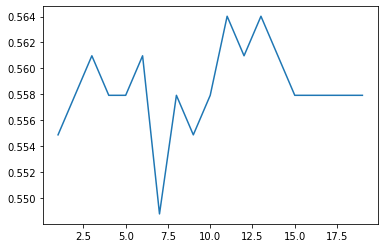

In [34]:
add_Edges = []
remove_Edges = []
accuracy = []
x = [i for i in range(1,20)]
for b in tqdm(range(1,20)):
    acc = batchApproach('../lMCI.txt','../AD.txt',batch_size=b)
    accuracy.append(acc)
plt.plot(x,accuracy)
plt.show()


  0%|          | 0/19 [00:00<?, ?it/s]

removed Matching Score::  0.11627906976744186
added Matching Score::  1.684782608695652
confusion matrix [[2132   40]
 [ 155 2573]]



  5%|▌         | 1/19 [02:04<37:20, 124.46s/it]

removed Matching Score::  0.11627906976744186
added Matching Score::  1.684782608695652
confusion matrix [[2132   40]
 [ 155 2573]]



 11%|█         | 2/19 [03:09<30:11, 106.56s/it]

removed Matching Score::  0.11627906976744186
added Matching Score::  1.673913043478261
confusion matrix [[2132   40]
 [ 154 2574]]



 16%|█▌        | 3/19 [03:46<22:50, 85.68s/it] 

removed Matching Score::  0.11627906976744186
added Matching Score::  1.6630434782608696
confusion matrix [[2132   40]
 [ 153 2575]]



 21%|██        | 4/19 [04:17<17:21, 69.44s/it]

removed Matching Score::  0.11627906976744186
added Matching Score::  1.684782608695652
confusion matrix [[2132   40]
 [ 155 2573]]



 26%|██▋       | 5/19 [04:46<13:21, 57.23s/it]

removed Matching Score::  0.11627906976744186
added Matching Score::  1.684782608695652
confusion matrix [[2132   40]
 [ 155 2573]]



 32%|███▏      | 6/19 [05:07<10:01, 46.30s/it]

removed Matching Score::  0.11627906976744186
added Matching Score::  1.684782608695652
confusion matrix [[2132   40]
 [ 155 2573]]



 37%|███▋      | 7/19 [05:32<08:00, 40.05s/it]

removed Matching Score::  0.12209302325581395
added Matching Score::  1.6521739130434783
confusion matrix [[2130   42]
 [ 152 2576]]



 42%|████▏     | 8/19 [05:49<06:04, 33.16s/it]

removed Matching Score::  0.11627906976744186
added Matching Score::  1.673913043478261
confusion matrix [[2132   40]
 [ 154 2574]]



 47%|████▋     | 9/19 [06:04<04:37, 27.76s/it]

removed Matching Score::  0.11627906976744186
added Matching Score::  1.673913043478261
confusion matrix [[2132   40]
 [ 154 2574]]



 53%|█████▎    | 10/19 [06:24<03:48, 25.39s/it]

removed Matching Score::  0.11627906976744186
added Matching Score::  1.673913043478261
confusion matrix [[2132   40]
 [ 154 2574]]



 58%|█████▊    | 11/19 [06:41<03:01, 22.67s/it]

removed Matching Score::  0.11627906976744186
added Matching Score::  1.6630434782608696
confusion matrix [[2132   40]
 [ 153 2575]]



 63%|██████▎   | 12/19 [06:53<02:16, 19.50s/it]

removed Matching Score::  0.11627906976744186
added Matching Score::  1.6630434782608696
confusion matrix [[2132   40]
 [ 153 2575]]



 68%|██████▊   | 13/19 [07:05<01:43, 17.23s/it]

removed Matching Score::  0.11627906976744186
added Matching Score::  1.684782608695652
confusion matrix [[2132   40]
 [ 155 2573]]



 74%|███████▎  | 14/19 [07:20<01:23, 16.66s/it]

removed Matching Score::  0.11627906976744186
added Matching Score::  1.684782608695652
confusion matrix [[2132   40]
 [ 155 2573]]



 79%|███████▉  | 15/19 [07:35<01:04, 16.14s/it]

removed Matching Score::  0.11627906976744186
added Matching Score::  1.673913043478261
confusion matrix [[2132   40]
 [ 154 2574]]



 84%|████████▍ | 16/19 [07:46<00:43, 14.60s/it]

removed Matching Score::  0.11627906976744186
added Matching Score::  1.6630434782608696
confusion matrix [[2132   40]
 [ 153 2575]]



 89%|████████▉ | 17/19 [07:55<00:26, 13.01s/it]

removed Matching Score::  0.11918604651162791
added Matching Score::  1.641304347826087
confusion matrix [[2131   41]
 [ 151 2577]]



 95%|█████████▍| 18/19 [08:05<00:12, 12.07s/it]

removed Matching Score::  0.11918604651162791
added Matching Score::  1.6521739130434783
confusion matrix [[2131   41]
 [ 152 2576]]



100%|██████████| 19/19 [08:18<00:00, 26.24s/it]


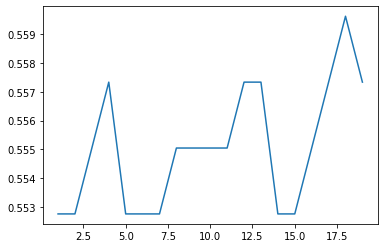

In [35]:
add_Edges = []
remove_Edges = []
accuracy = []
x = [i for i in range(1,20)]
for b in tqdm(range(1,20)):
    acc = batchApproach('../normal.txt','../AD.txt',batch_size=b)
    accuracy.append(acc)
plt.plot(x,accuracy)
plt.show()